In [4]:
import numpy as np
import numpy.matlib
from matplotlib import pyplot as plt
import pandas as pd
import math
import time
from keras.datasets import mnist

In [55]:
## Flatten the images
n_train = 100
n_test = 100
(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x = train_x[:n_train]
train_y = train_y[:n_train]
test_x = test_x[:n_test]
test_y = test_y[:n_test]

## Normalize the rgb values
train_image_x = train_x/255
test_image_x = test_x/255

## Flatten the images
train_x = train_image_x.reshape(train_x.shape[0], -1)
test_x = test_image_x.reshape(test_x.shape[0], -1)


In [56]:
def getEuclideanDistance(single_point,array):
    nrows, ncols, nfeatures=array.shape[0],array.shape[1], array.shape[2]
    points=array.reshape((nrows*ncols,nfeatures))
                         
    dist = (points - single_point)**2
    dist = np.sum(dist, axis=1)
    dist = np.sqrt(dist)

    dist=dist.reshape((nrows,ncols))
    return dist

In [57]:

mu, sigma = 0, 0.1
A = np.random.normal(mu, sigma, 10)
#A.shape, A

In [8]:
nrows,ncols,nfeatures=3,3,3

#Generate coordinate system
x,y=np.meshgrid(range(ncols),range(nrows))

In [9]:

sgm0=2
sgmdecay=0.05
t=1
sgm = sgm0 * math.exp(-t*sgmdecay);

width = math.ceil(sgm*3)

dist=np.array([[2,1,3],[3,2,3],[4,4,4]])
bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape) 

g = np.exp(-((np.power(x - bmucol,2)) + (np.power(y - bmurow,2))) / (2*sgm*sgm));


fromrow = max(0,bmurow - width);
torow   = min(bmurow + width,nrows);
fromcol = max(0,bmucol - width);
tocol   = min(bmucol + width,ncols);



In [10]:
G = np.dstack([g[fromrow:torow,fromcol:tocol]]*nfeatures);



In [11]:
def display_som(som, nrows, ncols, dispRes, title):
    print("\n" + title + "\n")
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
    for k in range(nrows):
        for l in range(ncols):
            A = som[k, l, :].reshape(dispRes)
            ax[k, l].imshow(A, cmap="plasma")
            ax[k, l].set_yticks([])
            ax[k, l].set_xticks([])
    plt.show()

In [12]:
def SOM(dispRes, trainingData, ndim=10, nepochs=10, eta0=0.1, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=0):
    nfeatures=trainingData.shape[1]
    ntrainingvectors=trainingData.shape[0]
    
    nrows = ndim
    ncols = ndim
    
    mu, sigma = 0, 0.1
    numpy.random.seed(int(time.time()))
    som = np.random.normal(mu, sigma, (nrows,ncols,nfeatures))

    if showMode >= 1:
        # print("\nSOM features before training: \n")
        display_som(som, nrows, ncols, dispRes, "SOM features before training")
        
        # fig, ax=plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
        
        # for k in range(nrows):
        #     for l in range (ncols):
        #         A=som[k,l,:].reshape((dispRes[0],dispRes[1]))
        #         ax[k,l].imshow(A,cmap="plasma")
        #         ax[k,l].set_yticks([])
        #         ax[k,l].set_xticks([])   
    
    #Generate coordinate system
    x,y=np.meshgrid(range(ncols),range(nrows))
    
    
    for t in range (1,nepochs+1):
        #Compute the learning rate for the current epoch
        eta = eta0 * math.exp(-t*etadecay);
        
        #Compute the variance of the Gaussian (Neighbourhood) function for the ucrrent epoch
        sgm = sgm0 * math.exp(-t*sgmdecay);
        
        #Consider the width of the Gaussian function as 3 sigma
        width = math.ceil(sgm*3);
        
        for ntraining in range(ntrainingvectors):
            trainingVector = trainingData[ntraining,:];
            
            # Compute the Euclidean distance between the training vector and
            # each neuron in the SOM map
            dist = getEuclideanDistance(trainingVector, som);
       
            # Find 2D coordinates of the Best Matching Unit (bmu)
            bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape) ;
            
            
            #Generate a Gaussian function centered on the location of the bmu
            g = np.exp(-((np.power(x - bmucol,2)) + (np.power(y - bmurow,2))) / (2*sgm*sgm));

            #Determine the boundary of the local neighbourhood
            fromrow = max(0,bmurow - width);
            torow   = min(bmurow + width,nrows);
            fromcol = max(0,bmucol - width);
            tocol   = min(bmucol + width,ncols);

            
            #Get the neighbouring neurons and determine the size of the neighbourhood
            neighbourNeurons = som[fromrow:torow,fromcol:tocol,:];
            sz = neighbourNeurons.shape;
            
            #Transform the training vector and the Gaussian function into 
            # multi-dimensional to facilitate the computation of the neuron weights update
            T = np.matlib.repmat(trainingVector,sz[0]*sz[1],1).reshape((sz[0],sz[1],nfeatures));                   
            G = np.dstack([g[fromrow:torow,fromcol:tocol]]*nfeatures);

            # Update the weights of the neurons that are in the neighbourhood of the bmu
            neighbourNeurons = neighbourNeurons + eta * G * (T - neighbourNeurons);

            
            #Put the new weights of the BMU neighbouring neurons back to the
            #entire SOM map
            som[fromrow:torow,fromcol:tocol,:] = neighbourNeurons;
        if showMode >= 1 and t == nepochs // 2:
                display_som(som, nrows, ncols, dispRes, "SOM features at 50% training")


    if showMode >= 1:
        display_som(som, nrows, ncols, dispRes, "SOM features after training")
        # print("\nSOM features AFTER training: \n")
        
        # fig, ax=plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
        
        # for k in range(nrows):
        #     for l in range (ncols):
        #         A=som[k,l,:].reshape((dispRes[0],dispRes[1]))
        #         ax[k,l].imshow(A,cmap="plasma")
        #         ax[k,l].set_yticks([])
        #     ax[k,l].set_xticks([])   
    return som
    

In [13]:
def parse_input_zoo_data(filename, header='infer'):

    input_data = pd.read_csv(filename, header=header)

    classes = input_data[17].tolist()
    labels = input_data[0].tolist()
    input_database = {
        0: input_data.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]].values
    }

    return input_database, labels, classes

In [14]:
input_filename = 'zoo.txt'
input_vector_database, labels, classes = parse_input_zoo_data(input_filename,None)








SOM features before training



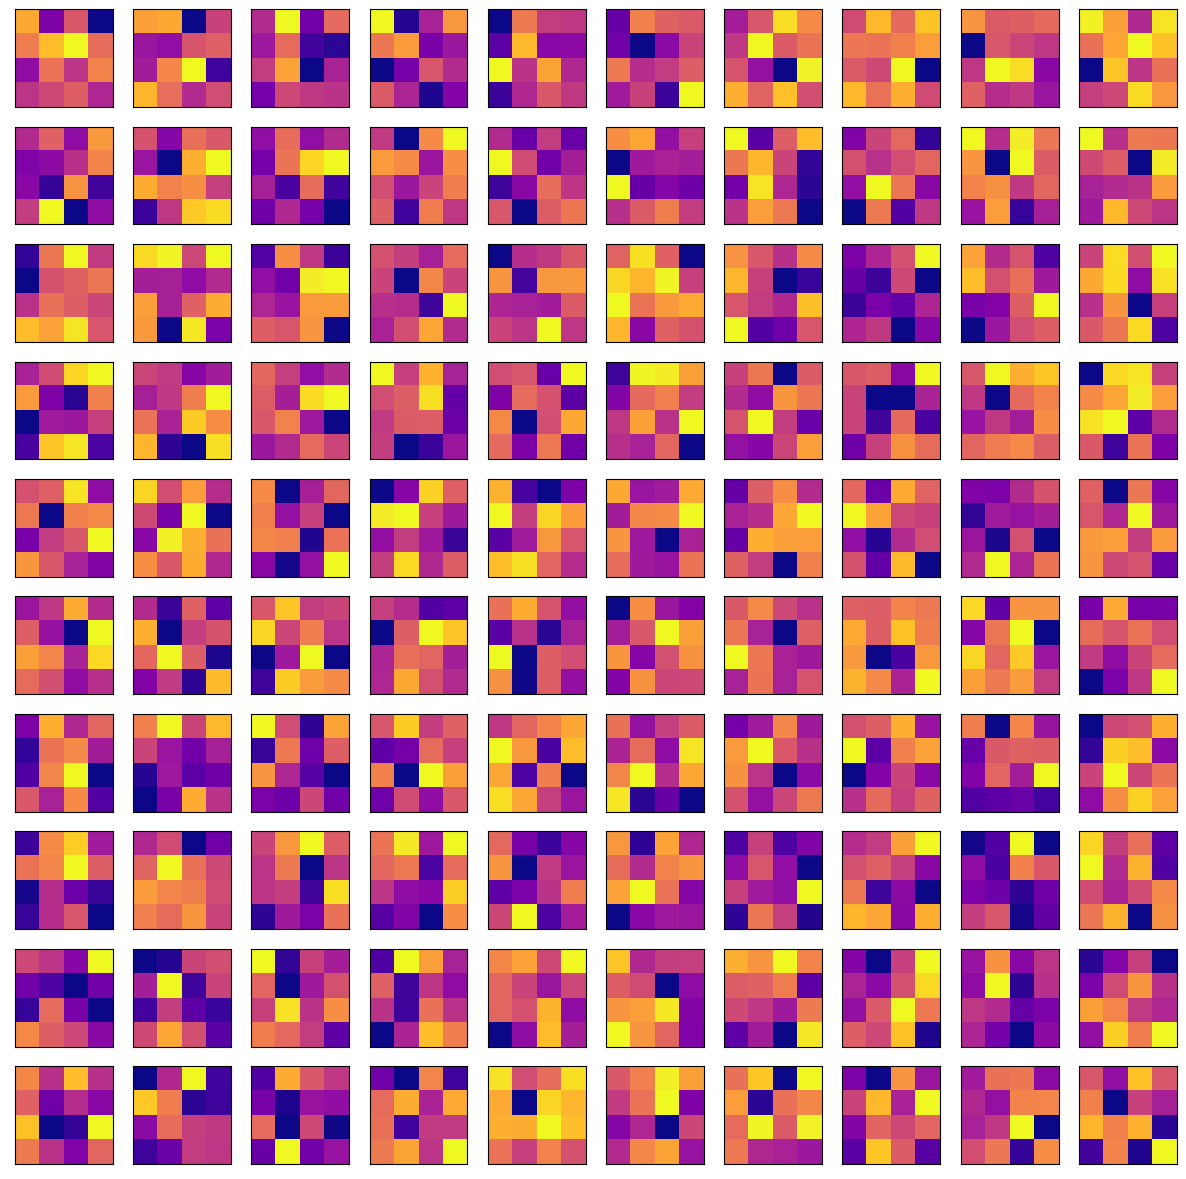


SOM features at 50% training



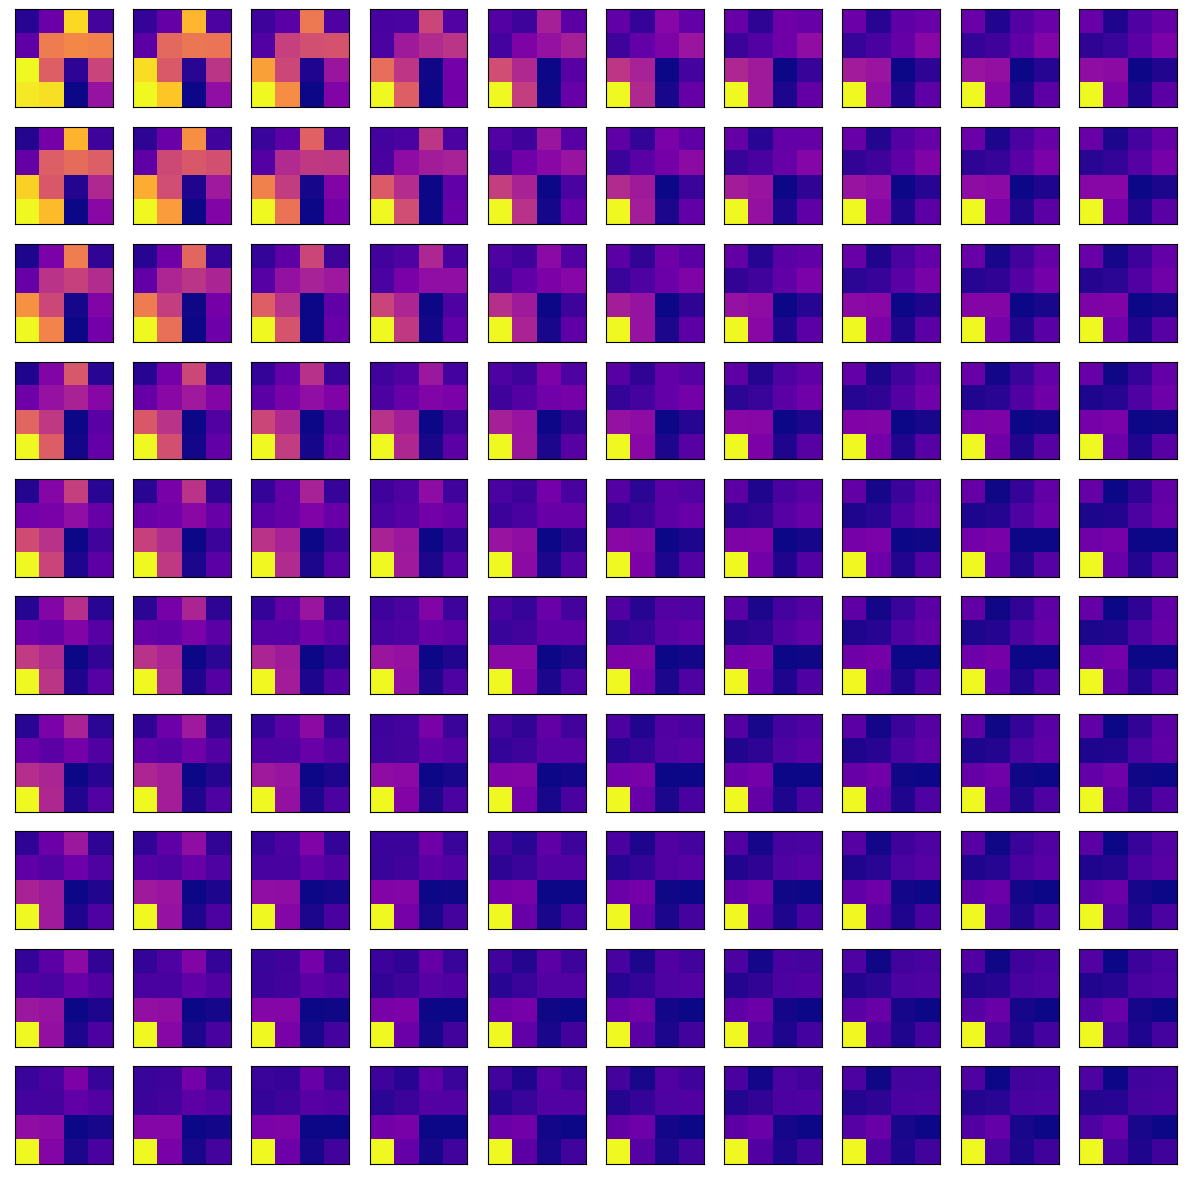


SOM features after training



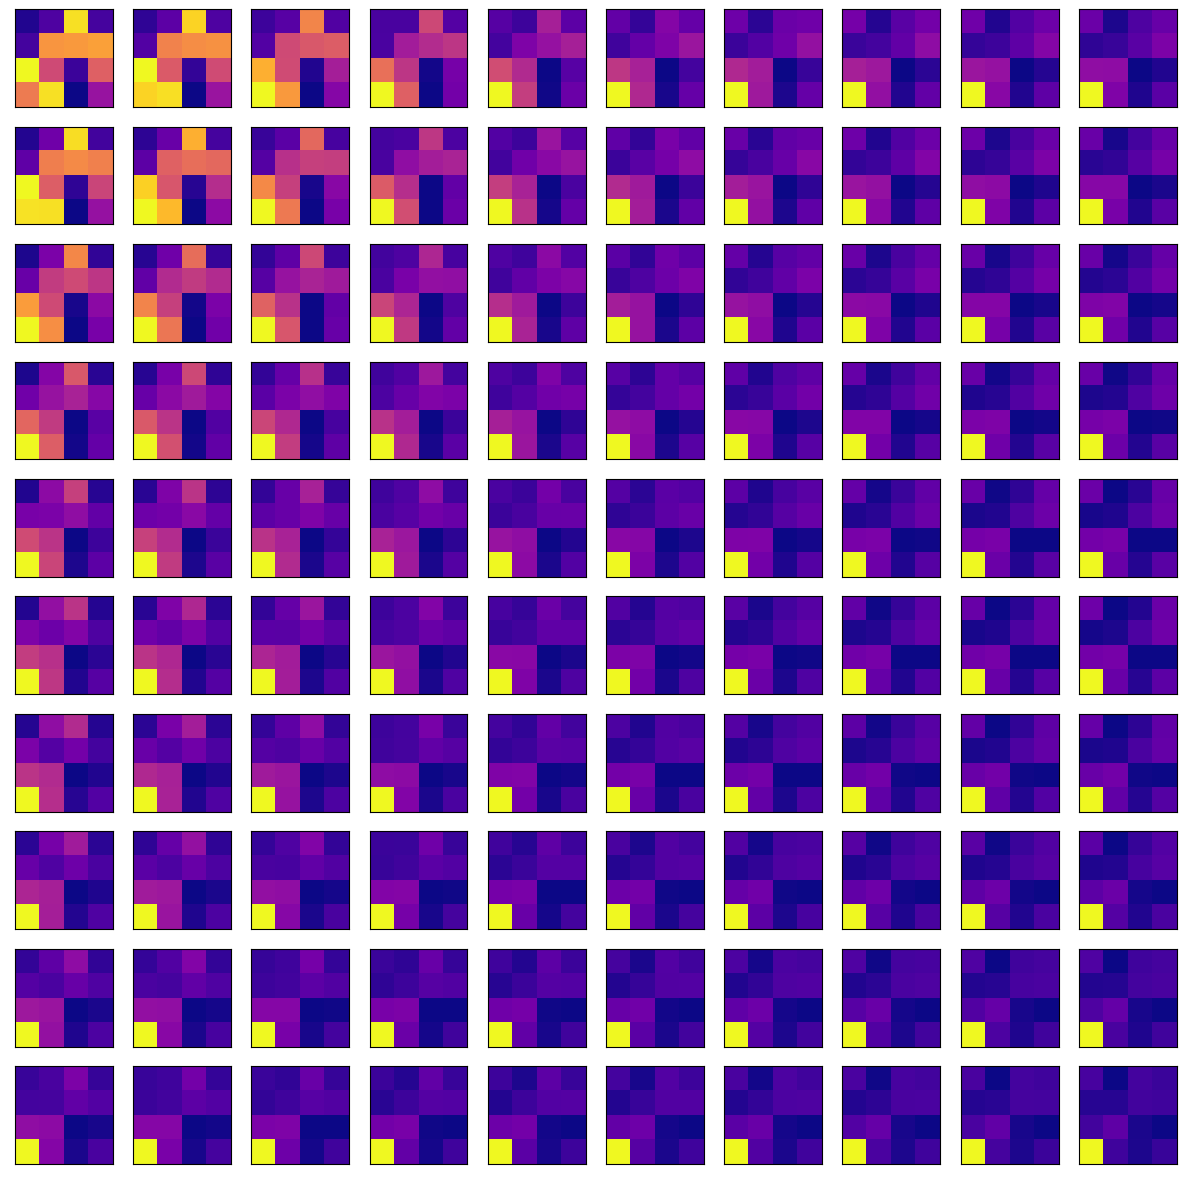

In [15]:
som_trained=SOM([4,4],input_vector_database[0], ndim=10, nepochs=100, eta0=0.01, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=1)




SOM features before training



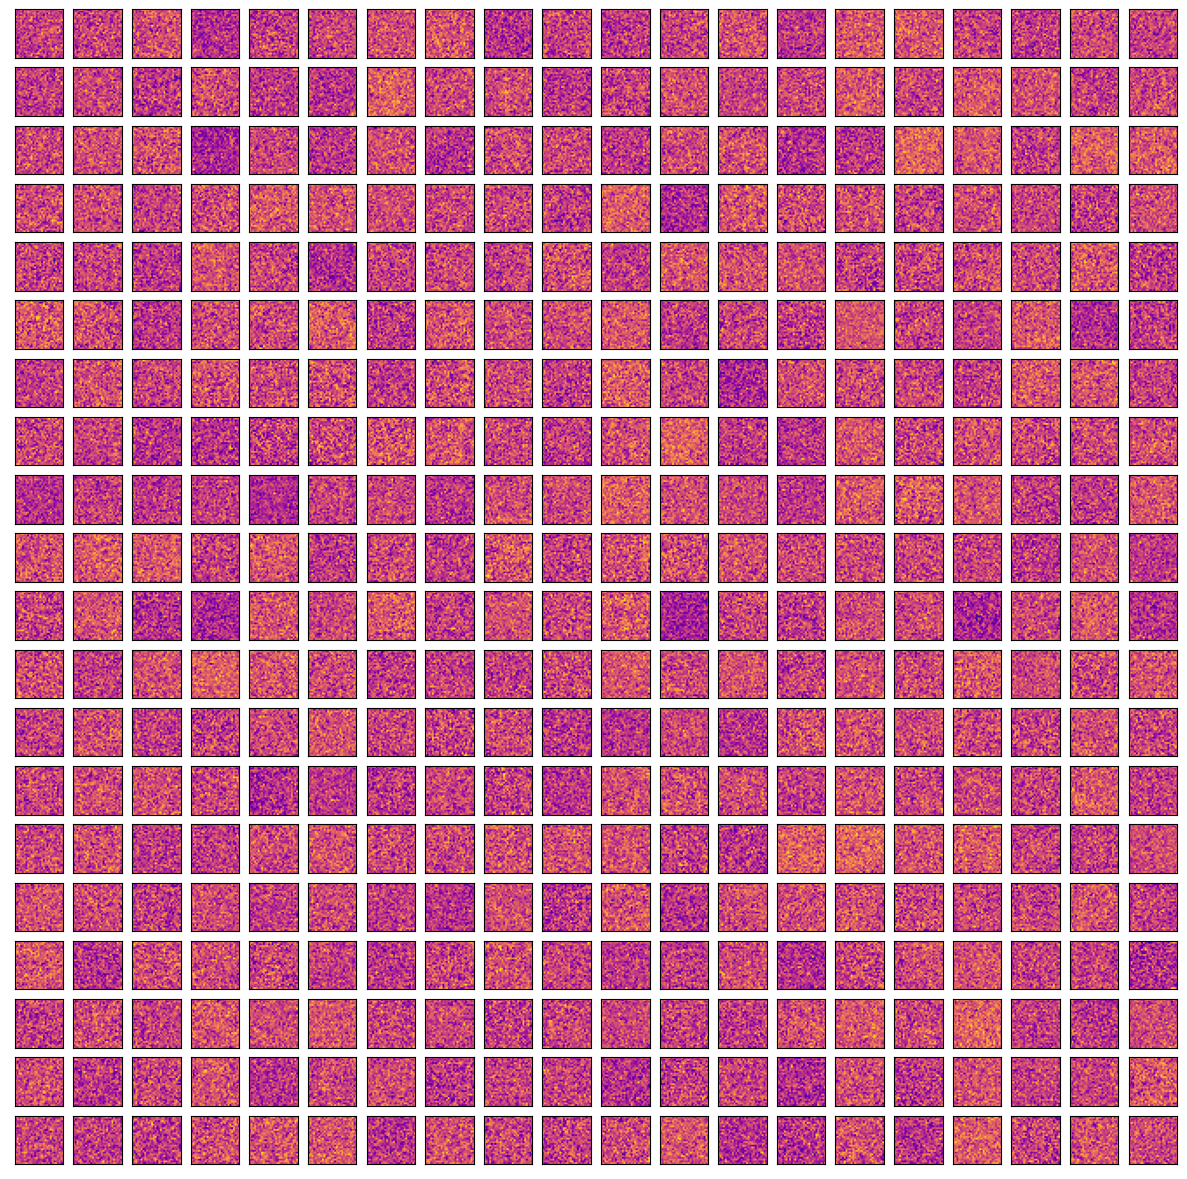


SOM features at 50% training



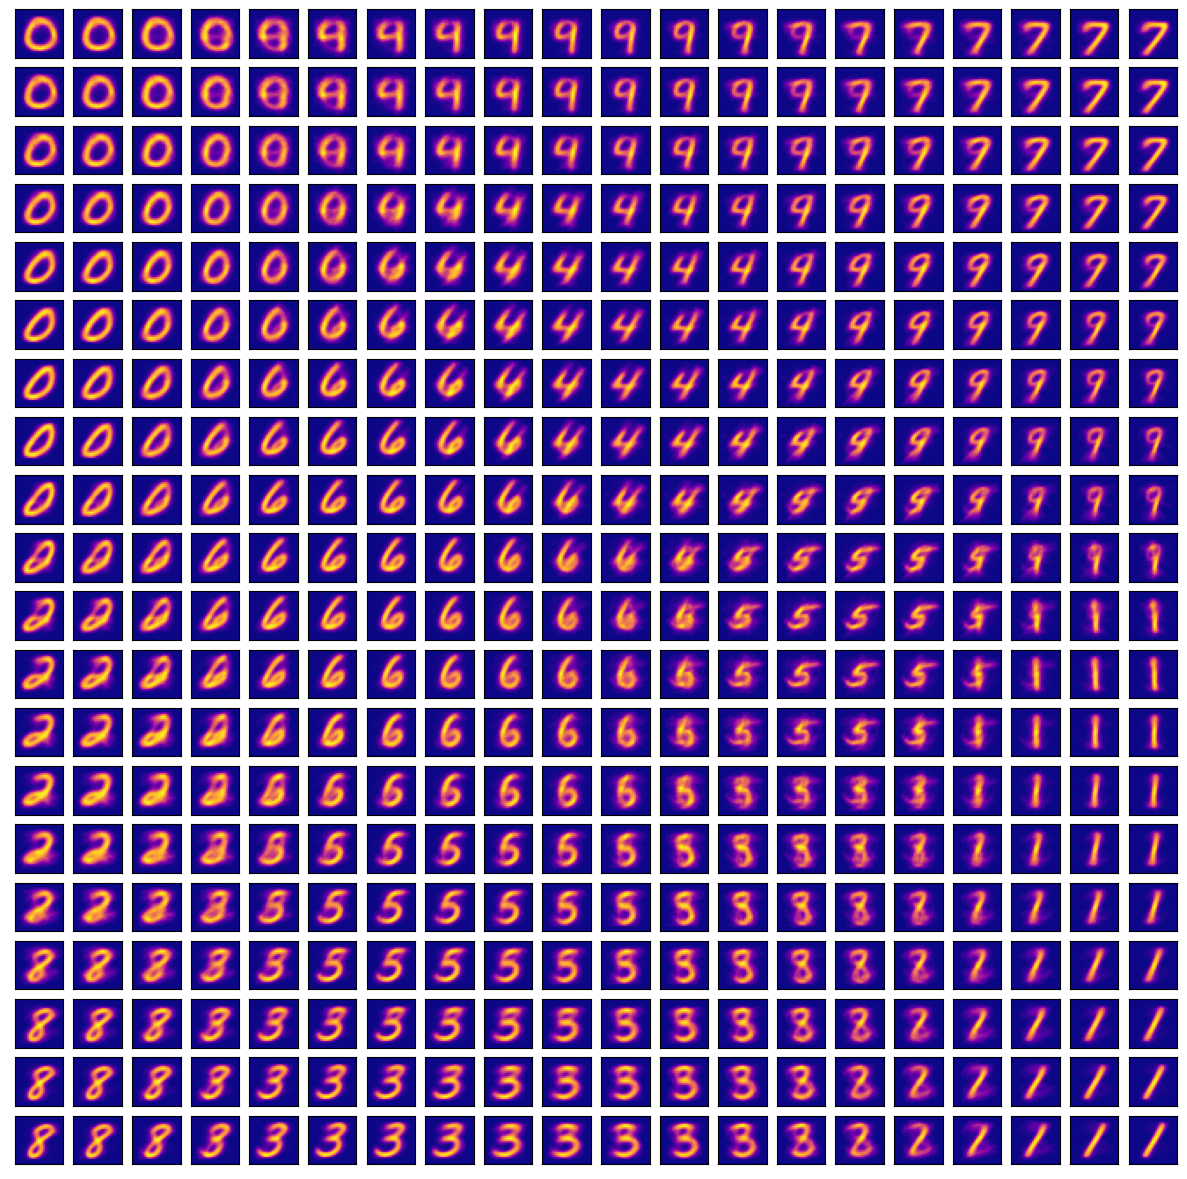


SOM features after training



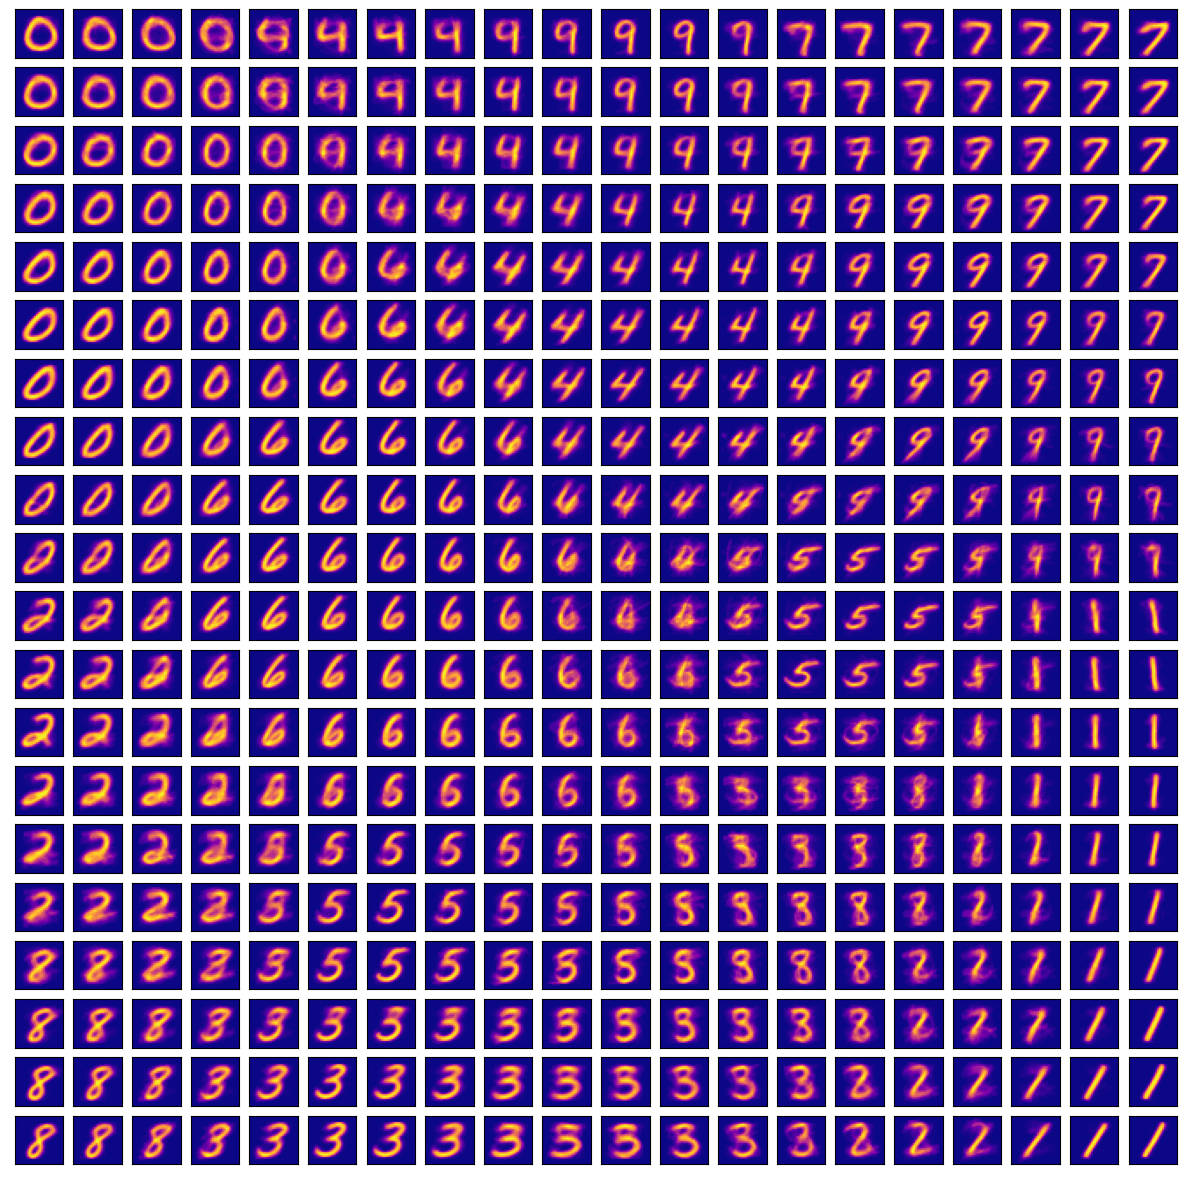

[[[-3.79098245e-275 -8.55456163e-275 -7.62187350e-275 ...
   -1.99239487e-274  3.76799507e-275 -4.23076613e-277]
  [-1.42288985e-284 -1.50059784e-284 -1.54844372e-284 ...
    4.68365176e-285  1.17894763e-284  1.28639141e-284]
  [-1.47099966e-293  1.11014088e-293 -2.77343358e-293 ...
   -1.65598604e-293  1.80952858e-293 -2.09980320e-293]
  ...
  [-1.30996565e-319  2.40906409e-320 -1.83150135e-320 ...
   -9.16738806e-320  2.19414553e-320 -2.28604174e-320]
  [-5.72141144e-312  2.30398732e-313  1.09597467e-311 ...
    2.79375635e-312 -1.77490301e-312 -1.28255554e-312]
  [ 6.25182581e-303  3.40055147e-302  4.09546924e-302 ...
    3.33686579e-302 -6.19193089e-303  9.09117332e-303]]

 [[ 3.29448048e-284 -3.86553151e-284  4.21499612e-285 ...
    4.55616775e-284  6.00178246e-284 -8.24564520e-284]
  [ 1.25602135e-294  8.15628220e-295  3.18789979e-294 ...
    3.56848890e-295  2.22403785e-294  5.38791380e-295]
  [-6.10876873e-304  4.04209614e-304  9.53410019e-304 ...
   -7.15720722e-304  7.2853250

In [16]:
ndim20 = 20
ndim40 = 40
ndim80 = 80

som_trained_20x20 = SOM([28, 28], train_x, ndim=ndim20, nepochs=100, showMode=1)

print(som_trained_20x20)

plt.show()

In [17]:
plt.show()


In [18]:
#verification of correctness on the training set:



def SOM_Test (trainingData, som_, classes, grid_, ConfusionMatrix, ndim=60):
    nfeatures=trainingData.shape[1]
    ntrainingvectors=trainingData.shape[0]
    
    nrows = ndim
    ncols = ndim
    
    nclasses=np.max(classes)

    som_cl=np.zeros((ndim,ndim,nclasses+1))
    
    
    for ntraining in range(ntrainingvectors):
        trainingVector = trainingData[ntraining,:];
        class_of_sample= classes[ntraining]    
        # Compute the Euclidean distance between the training vector and
        # each neuron in the SOM map
        dist = getEuclideanDistance(trainingVector, som_);
       
        # Find 2D coordinates of the Best Matching Unit (bmu)
        bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape) ;
        
        
        som_cl[bmurow, bmucol,class_of_sample]=som_cl[bmurow, bmucol,class_of_sample]+1
    
    
    
    for i in range (nrows):
        for j in range (ncols):
            grid_[i,j]=np.argmax(som_cl[i,j,:])

 
    for ntraining in range(ntrainingvectors):
        trainingVector = trainingData[ntraining,:];
        class_of_sample= classes[ntraining]    
        # Compute the Euclidean distance between the training vector and
        # each neuron in the SOM map
        dist = getEuclideanDistance(trainingVector, som_);
       
        # Find 2D coordinates of the Best Matching Unit (bmu)
        bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape) ;
        
        predicted=np.argmax(som_cl[bmurow, bmucol,:])
        ConfusionMatrix[class_of_sample-1, predicted-1]=ConfusionMatrix[class_of_sample-1, predicted-1]+1
        
    return grid_, ConfusionMatrix
    



In [ ]:
def getConfusionMatrix(train_images, SOM, ndim=20):
    nrows=ndim
    ncols=ndim
    grid_color=np.zeros((nrows,ncols))
    nclasses=np.max(classes)

    Confusion_Matrix=np.zeros((nclasses,nclasses))
    grid_color,Confusion_Matrix=SOM_Test (train_images, SOM, classes, grid_color, Confusion_Matrix, ndim)

    plt.close()
    plt.imshow(grid_color)
    plt.show()

    return Confusion_Matrix, train_images.shape, np.sum(Confusion_Matrix)

In [58]:
def calulateAccuracy(Confusion_Matrix):
    true_positives = np.trace(Confusion_Matrix)

    # Calculate the total number of samples (the sum of all elements in the confusion matrix)
    total_samples = np.sum(Confusion_Matrix)

    # Calculate accuracy
    accuracy = true_positives / total_samples

    print("Accuracy:", accuracy)

Training Set


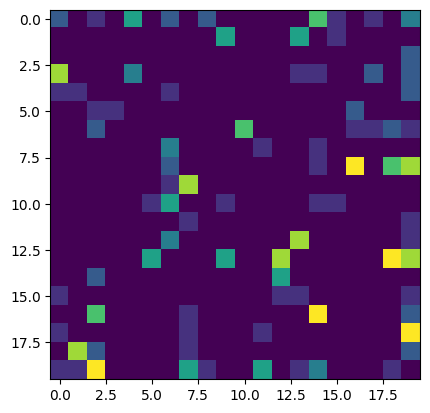

[[41.  0.  0.  0.  0.  0.  0.]
 [ 4. 15.  0.  0.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.  0.]
 [ 2.  2.  0.  9.  0.  0.  0.]
 [ 0.  0.  0.  0.  4.  0.  0.]
 [ 0.  1.  0.  0.  0.  7.  0.]
 [ 2.  2.  1.  0.  0.  0.  5.]]
Accuracy: 0.86
Test Set


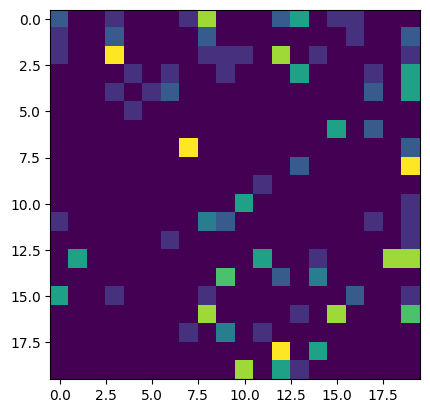

[[41.  0.  0.  0.  0.  0.  0.]
 [ 6. 13.  0.  0.  0.  0.  0.]
 [ 1.  1.  3.  0.  0.  0.  0.]
 [ 1.  0.  0. 12.  0.  0.  0.]
 [ 1.  0.  0.  1.  2.  0.  0.]
 [ 0.  1.  0.  0.  0.  7.  0.]
 [ 3.  1.  0.  0.  0.  1.  5.]]
Accuracy: 0.83


In [61]:
# 5
print("Training Set")
confusion_matrix, shape, sum_matrix = getConfusionMatrix(train_x, som_trained_20x20, ndim20)
print(confusion_matrix)
calulateAccuracy(confusion_matrix)

print("Test Set")
confusion_matrix, shape, sum_matrix = getConfusionMatrix(test_x, som_trained_20x20, ndim20)
print(confusion_matrix)
calulateAccuracy(confusion_matrix)


--- Training with learning rate: 0.01 ---


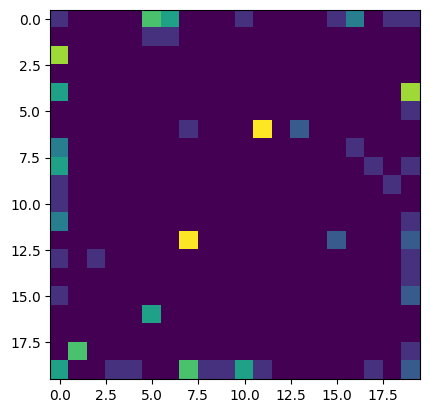

[[37.  3.  0.  1.  0.  0.  0.]
 [ 7. 10.  0.  2.  0.  0.  0.]
 [ 2.  0.  3.  0.  0.  0.  0.]
 [ 1.  1.  0. 11.  0.  0.  0.]
 [ 0.  1.  0.  0.  3.  0.  0.]
 [ 4.  0.  0.  2.  0.  2.  0.]
 [ 4.  3.  0.  1.  0.  0.  2.]]
Accuracy: 0.68

--- Training with learning rate: 0.1 ---


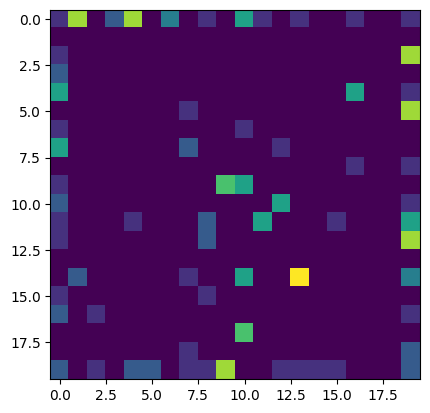

[[39.  2.  0.  0.  0.  0.  0.]
 [ 3. 16.  0.  0.  0.  0.  0.]
 [ 2.  1.  2.  0.  0.  0.  0.]
 [ 3.  0.  1.  9.  0.  0.  0.]
 [ 1.  0.  1.  0.  2.  0.  0.]
 [ 2.  0.  0.  0.  0.  6.  0.]
 [ 3.  4.  0.  1.  0.  1.  1.]]
Accuracy: 0.75

--- Training with learning rate: 0.25 ---


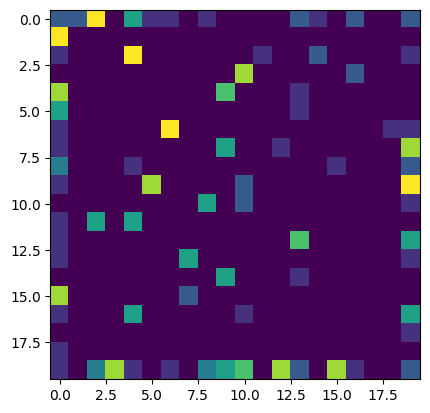

[[39.  2.  0.  0.  0.  0.  0.]
 [ 3. 16.  0.  0.  0.  0.  0.]
 [ 1.  1.  3.  0.  0.  0.  0.]
 [ 1.  0.  0. 12.  0.  0.  0.]
 [ 1.  0.  0.  0.  3.  0.  0.]
 [ 0.  0.  0.  0.  0.  8.  0.]
 [ 2.  1.  0.  1.  0.  1.  5.]]
Accuracy: 0.86

--- Training with learning rate: 0.5 ---


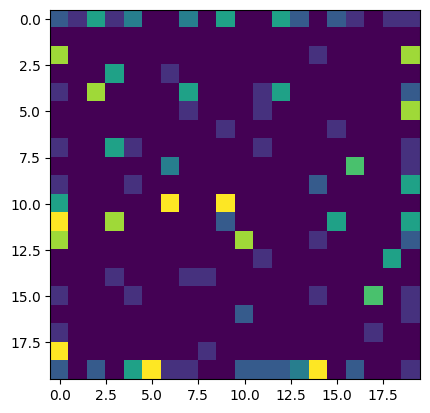

[[40.  1.  0.  0.  0.  0.  0.]
 [ 2. 17.  0.  0.  0.  0.  0.]
 [ 0.  1.  4.  0.  0.  0.  0.]
 [ 0.  0.  0. 13.  0.  0.  0.]
 [ 1.  0.  0.  1.  2.  0.  0.]
 [ 1.  0.  0.  0.  0.  7.  0.]
 [ 0.  3.  0.  0.  0.  1.  6.]]
Accuracy: 0.89

--- Training with learning rate: 0.75 ---


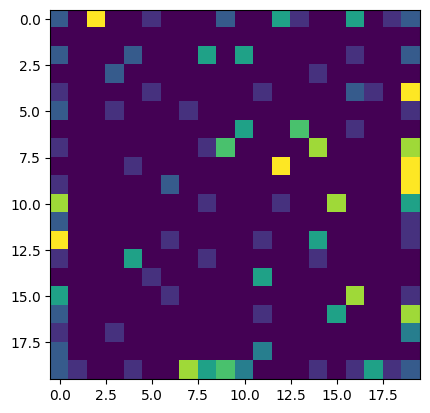

[[41.  0.  0.  0.  0.  0.  0.]
 [ 2. 17.  0.  0.  0.  0.  0.]
 [ 1.  1.  3.  0.  0.  0.  0.]
 [ 0.  0.  0. 13.  0.  0.  0.]
 [ 1.  0.  0.  0.  3.  0.  0.]
 [ 0.  1.  0.  0.  0.  7.  0.]
 [ 1.  3.  0.  0.  0.  0.  6.]]
Accuracy: 0.9

--- Training with learning rate: 0.85 ---


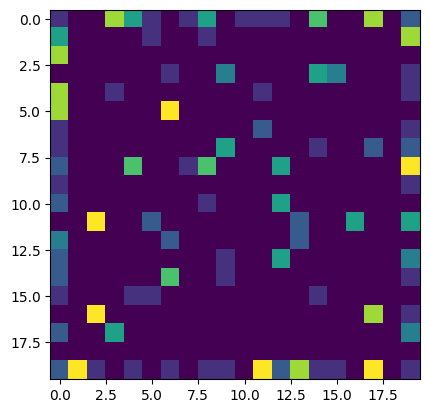

[[40.  1.  0.  0.  0.  0.  0.]
 [ 3. 16.  0.  0.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.  0.]
 [ 2.  0.  0. 11.  0.  0.  0.]
 [ 0.  0.  0.  0.  4.  0.  0.]
 [ 0.  0.  0.  0.  0.  8.  0.]
 [ 0.  1.  0.  1.  0.  1.  7.]]
Accuracy: 0.91

--- Training with learning rate: 0.95 ---


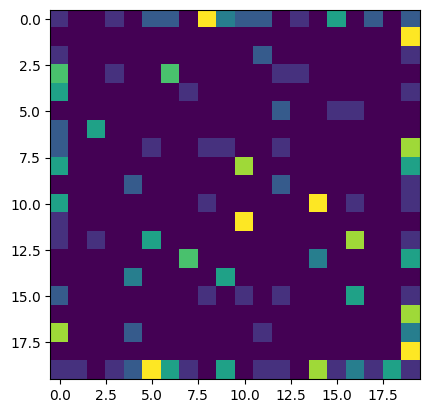

[[40.  1.  0.  0.  0.  0.  0.]
 [ 3. 16.  0.  0.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.  0.]
 [ 0.  0.  0. 13.  0.  0.  0.]
 [ 1.  0.  0.  0.  3.  0.  0.]
 [ 1.  1.  0.  0.  0.  6.  0.]
 [ 0.  1.  0.  2.  0.  1.  6.]]
Accuracy: 0.89


In [62]:
# learning rates
learning_rates = [0.01, 0.1, 0.25, 0.5, 0.75, 0.85, 0.95]

for eta0 in learning_rates:
    print(f"\n--- Training with learning rate: {eta0} ---")
    som = SOM([28, 28], train_x, ndim=ndim20, nepochs=100, eta0=eta0, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=0)
    
    confusion_matrix, shape, sum_matrix = getConfusionMatrix(train_x, som, ndim20)
    print(confusion_matrix)
    calulateAccuracy(confusion_matrix)

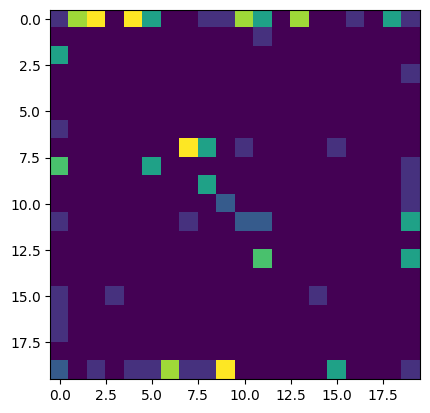

[[38.  3.  0.  0.  0.  0.  0.]
 [10.  9.  0.  0.  0.  0.  0.]
 [ 4.  1.  0.  0.  0.  0.  0.]
 [ 2.  0.  0. 11.  0.  0.  0.]
 [ 1.  1.  0.  0.  2.  0.  0.]
 [ 3.  0.  0.  0.  1.  4.  0.]
 [ 5.  1.  0.  0.  0.  0.  4.]]
Accuracy: 0.68


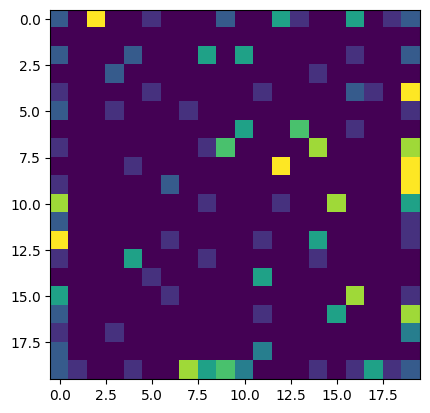

[[41.  0.  0.  0.  0.  0.  0.]
 [ 2. 17.  0.  0.  0.  0.  0.]
 [ 1.  1.  3.  0.  0.  0.  0.]
 [ 0.  0.  0. 13.  0.  0.  0.]
 [ 1.  0.  0.  0.  3.  0.  0.]
 [ 0.  1.  0.  0.  0.  7.  0.]
 [ 1.  3.  0.  0.  0.  0.  6.]]
Accuracy: 0.9


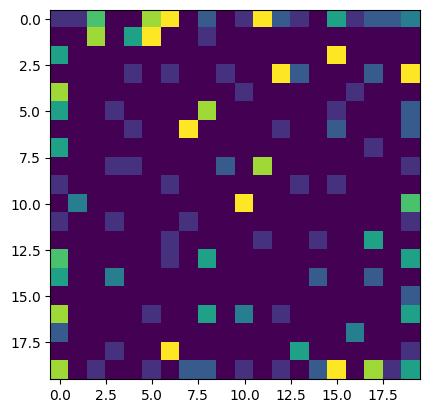

[[41.  0.  0.  0.  0.  0.  0.]
 [ 2. 17.  0.  0.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.  0.]
 [ 0.  0.  0. 13.  0.  0.  0.]
 [ 1.  0.  0.  0.  3.  0.  0.]
 [ 0.  0.  0.  0.  0.  8.  0.]
 [ 0.  0.  0.  0.  0.  0. 10.]]
Accuracy: 0.97


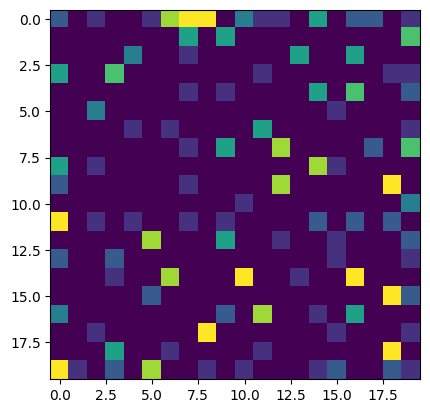

[[41.  0.  0.  0.  0.  0.  0.]
 [ 1. 18.  0.  0.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.  0.]
 [ 0.  0.  0. 13.  0.  0.  0.]
 [ 0.  0.  0.  0.  4.  0.  0.]
 [ 0.  0.  0.  0.  0.  8.  0.]
 [ 0.  0.  0.  0.  0.  0. 10.]]
Accuracy: 0.99


In [63]:
# Best learning rate we got: 0.85

sgmdecay_values = [0.01, 0.05, 0.1, 0.5]
for sgmdecay in sgmdecay_values:
    som = SOM([28, 28], train_x, ndim=20, nepochs=100, eta0=0.75, etadecay=0.05, sgm0=20, sgmdecay=sgmdecay, showMode=0)

    confusion_matrix, shape, sum_matrix = getConfusionMatrix(train_x, som, ndim20)
    print(confusion_matrix)
    calulateAccuracy(confusion_matrix)

In [ ]:
# 8
# We can see that the accuracy is higher for the training set than for the test set. This is because the SOM is trained on the training set, and therefore it is better at classifying the training set than the test set. The SOM is overfitted to the training set.

In [ ]:
# 9